In [21]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
%matplotlib inline

### References

1. https://github.com/ChadFulton/tsa-notebooks/blob/master/bernoulli_trials_bayesian.ipynb
2. https://analyticsindiamag.com/thompson-sampling-explained-with-python-code/

### Bernoulli trial

Let $y$ be a Bernoulli trial:

$y \sim \text{Bernoulli}(\theta) = \text{Binomial}(1, \theta)$

The probability density function, or marginal likelihood function, is:

$$p(y|\theta) = \theta^{y} (1-\theta)^{1-y} = \begin{cases}
\theta & y = 1 \\
1 - \theta & y = 0
\end{cases}$$

Bernoulli trials are one of the simplest experimential setups: there are a number of iterations of some activity, where each iteration (or trial) may turn out to be a "success" or a "failure". From the data on T trials, we want to estimate the probability of "success".

In [16]:
# Simulate data
np.random.seed(123)

nobs = 100
theta = 0.3
Y = np.random.binomial(1, theta, nobs)

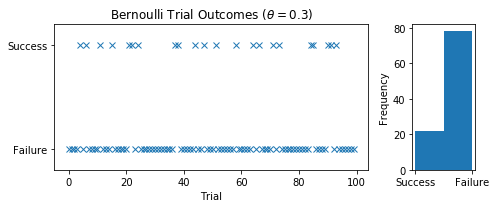

In [17]:
# Plot the data
fig = plt.figure(figsize=(7,3))
gs = gridspec.GridSpec(1, 2, width_ratios=[5, 1]) 
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax1.plot(range(nobs), Y, 'x')
ax2.hist(-Y, bins=2)

ax1.yaxis.set(ticks=(0,1), ticklabels=('Failure', 'Success'))
ax2.xaxis.set(ticks=(-1,0), ticklabels=('Success', 'Failure'));

ax1.set(title=r'Bernoulli Trial Outcomes $(\theta=0.3)$', xlabel='Trial', ylim=(-0.2, 1.2))
ax2.set(ylabel='Frequency')

fig.tight_layout()

### Bayesian Estimation

Using Bayes' rule:

$$p(\theta|Y) = \frac{p(Y|\theta) p(\theta)}{p(Y)}$$

To perform Bayesian estimation, we need to construct the __posterior__ $p(\theta|Y)$ given:

- the (joint) __likelihood__ $P(Y|\theta)$
- the __prior__ $p(\theta)$
- the __marginal probability density function__ $P(Y)$

to perform the estimation, we need to specify the functional forms of the likelihood and the prior. The marginal pdf of $Y$ is a constant with respect to $\theta$, so it does not need to specified for our purposes.

### Likelihood function

Consider a sample of $T$ draws from the random variable $y$. The joint likelihood of observing any specific sample $Y = (y_1, ..., y_T)'$ is given by:

$$
\begin{align}
p(Y|\theta) & = \prod_{i=1}^T \theta^{y_i} (1-\theta)^{1-y_i} \\
& = \theta^{s} (1 - \theta)^{T-s}
\end{align}
$$

where $s = \sum_i y_i$ is the number of observed "successes", and $T-s$ is the number of observed "failures".

### Prior

Since $\theta$ is a probability value, our prior must respect $\theta \in (0,1)$. We will use the (conjugate) Beta prior:

$\theta \sim \text{Beta}(\alpha_1, \alpha_2)$

so that $(\alpha_1, \alpha_2)$ are the model's hyperparameters. Then the prior is specified as:

$$
p(\theta;\alpha_1,\alpha_2) = \frac{1}{B(\alpha_1, \alpha_2)} \theta^{\alpha_1-1} (1 - \theta)^{\alpha_2 - 1}
$$

where $B(\alpha_1, \alpha_2)$ is the Beta function. Note that to have a fully specified prior, we need to also specify the hyperparameters.

Prior mean: 0.5


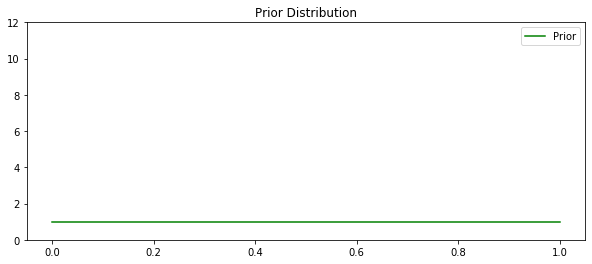

In [63]:
# For alpha_1 = alpha_2 = 1, the Beta distribution
# degenerates to a uniform distribution
a1 = 1
a2 = 1

# Prior Mean
prior_mean = a1 / (a1 + a2)
print('Prior mean:', prior_mean)

# Plot the prior
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
X = np.linspace(0,1, 1000)
ax.plot(X, stats.beta(a1, a2).pdf(X), 'g');

# Cleanup
ax.set(title='Prior Distribution', ylim=(0,12))
ax.legend(['Prior']);

### Posterior

#### Analytically

Given the prior and the likelihood function, we can try to find the kernel of the posterior analytically. In this case, it will be possible:

$$
\begin{align}
p(\theta|Y;\alpha_1,\alpha_2) & = \frac{P(Y|\theta) P(\theta)}{P(Y)} \\
& \propto P(Y|\theta) P(\theta) \\
& = \theta^s (1-\theta)^{T-s} \frac{1}{B(\alpha_1, \alpha_2)} \theta^{\alpha_1-1} (1 - \theta)^{\alpha_2 - 1} \\
& \propto \theta^{s+\alpha_1-1} (1 - \theta)^{T-s+\alpha_2 - 1} \\
\end{align}
$$

The last line is identifiable as the kernel of a beta distribution with parameters $(\hat \alpha_1, \hat \alpha_2) = (s+\alpha_1, T-s+\alpha_2)$

Thus the posterior is given by

$$
P(\theta|Y;\alpha_1,\alpha_2) = \frac{1}{B(\hat \alpha_1, \hat \alpha_2)} \theta^{\hat \alpha_1 - 1} (1-\theta)^{\hat \alpha_2 -1}
$$

Posterior Mean (Analytic): 0.22549019607843138


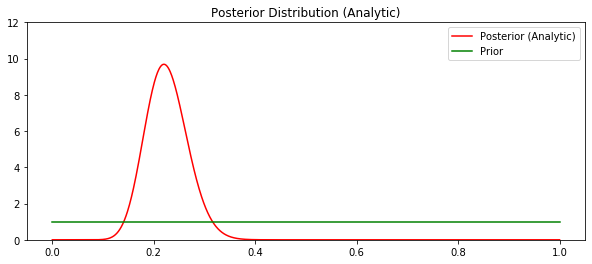

In [24]:
# Find the hyperparameters of the posterior
a1_hat = a1 + Y.sum()
a2_hat = a2 + nobs - Y.sum()

# Posterior Mean
post_mean = a1_hat / (a1_hat + a2_hat)
print('Posterior Mean (Analytic):', post_mean)

# Plot the analytic posterior
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
X = np.linspace(0,1, 1000)
ax.plot(X, stats.beta(a1_hat, a2_hat).pdf(X), 'r');

# Plot the prior
ax.plot(X, stats.beta(a1, a2).pdf(X), 'g');

# Cleanup
ax.set(title='Posterior Distribution (Analytic)', ylim=(0,12))
ax.legend(['Posterior (Analytic)', 'Prior']);

## Thompson Sampling

In [68]:
bandit_probs = [0.1,0.5,0.3,0.8,0.7]
data = np.array([stats.bernoulli.rvs(p,size=10000) for p in bandit_probs ]).T

In [80]:
[np.mean(data[:,i]) for i in range(5)]

[0.1034, 0.4992, 0.3018, 0.7957, 0.7026]

In [86]:
observations = 10000
machines = 5
machine_selected = []

rewards = [0] * machines
penalties = [0] * machines
total_reward = 0

In [88]:
penalties

[0, 0, 0, 0, 0]

In [90]:
data[1000,:]

array([1, 0, 0, 0, 0])

In [91]:
for n in range(0, observations):
    
    bandit = 0
    action_prob = np.zeros(machines)
    
    for i in range(0, machines):
        beta_d = random.betavariate(rewards[i] + 1, penalties[i] + 1)
        action_prob[i] = beta_d
        
    max_p = np.max(action_prob)
    bandit = np.random.choice(np.where(action_prob == max_p)[0])
    
        
    machine_selected.append(bandit)
        
    reward = data[n, bandit]
    
    if reward == 1:
        rewards[bandit] = rewards[bandit] + 1
    else:
        penalties[bandit] = penalties[bandit] + 1

    total_reward = total_reward + reward

print("\n\nRewards By Machine = ", rewards)
print("\nTotal Rewards = ", total_reward)
# print("\nMachine Selected At Each Round By Thompson Sampling : \n", machine_selected)



Rewards By Machine =  [0, 12, 1, 7657, 244]

Total Rewards =  7914


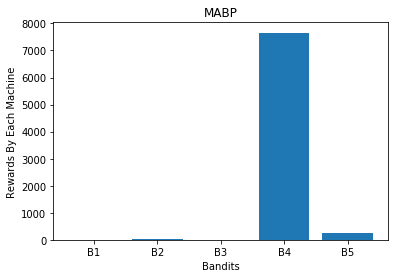

In [92]:
#Visualizing the rewards of each machine
plt.bar(['B1','B2','B3','B4','B5'],rewards)
plt.title('MABP')
plt.xlabel('Bandits')
plt.ylabel('Rewards By Each Machine')
plt.show()

In [93]:
#Number Of Times Each Machine Was Selected
from collections import Counter
print("\n\nNumber Of Times Each Machine Was Selected By The Thompson Sampling Algorithm : \n",dict(Counter(machine_selected)))



Number Of Times Each Machine Was Selected By The Thompson Sampling Algorithm : 
 {3: 9625, 0: 6, 2: 7, 4: 335, 1: 27}


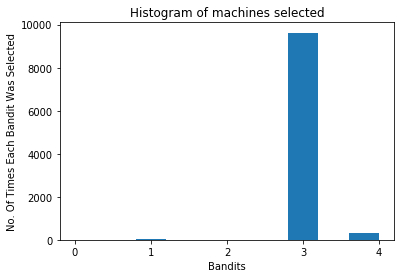

In [94]:
#Visualizing the Number Of Times Each Machine Was Selected
plt.hist(machine_selected)
plt.title('Histogram of machines selected')
plt.xlabel('Bandits')
plt.xticks(range(0, 5))
plt.ylabel('No. Of Times Each Bandit Was Selected')
plt.show()

In [95]:
[random.betavariate(rewards[i]+1,penalties[i]+1) for i in range(5)]

[0.0658646172806135,
 0.2618861693022717,
 0.09741529763385354,
 0.7959975107963503,
 0.6907208124954906]

In [96]:
bandit_probs

[0.1, 0.5, 0.3, 0.8, 0.7]